In [234]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from astropy.time import Time

In [226]:
def convert_to_ap_Time(df, key):
    print(key)
    df[key] = pd.to_datetime(df[key])
    df[key] = Time([t1.astype(str) for t1 in  df[key].values], format="isot")
    return df

def convert_times_to_datetime(df):
    columns = ["Gun Time", "Chip Time", "TOD", "Beat the Bridge", "Beat the Bridge.1"]
    
    for key in columns:
        df = convert_to_ap_Time(df, key)
        df = convert_Time_to_seconds(df, key)
    return df

def convert_Time_to_seconds(df, key):
    t0 = Time("2017-04-26T00:00:00.000", format="isot")
    df["sub" + key] = df[key] - t0
    df["sub" + key] = [t.sec for t in df["sub" + key].values]
    return df

In [227]:
results_path = "/Users/berto/Code/zoidberg/ABPSoton10k/data/Results10k.csv"

df = pd.read_csv(results_path)
# df = df.drop(df.index[len(df)-10:])
df = df.drop(df.loc[df["Gun Time"] == "DNF"].index)
df = df.drop(df.loc[df["Gun Time"] == "QRY"].index)
df = df.drop(df.loc[df["Beat the Bridge"] == "99:99:99"].index)

In [228]:
# df.tail(10)

<IPython.core.display.Javascript object>


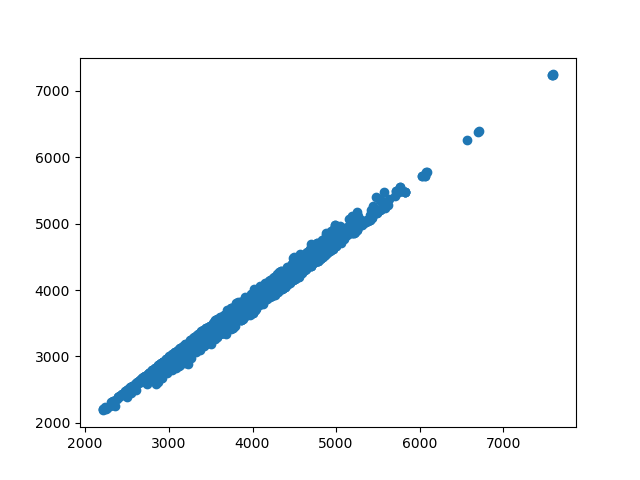

In [238]:
plt.scatter(df["subGun Time"], df["subChip Time"])

<IPython.core.display.Javascript object>


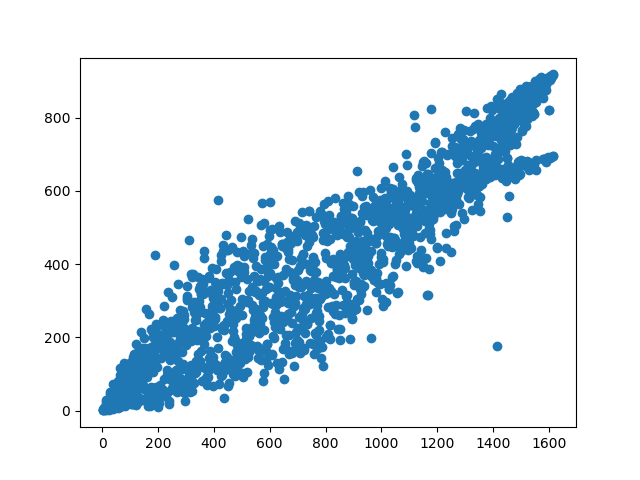

In [250]:
# plt.scatter(df["Pos"], df["subChip Time"])
# plt.scatter(df["subChip Time"], df["subBeat the Bridge"])
plt.scatter(df["Pos"], df["G/Pos"])

In [239]:
df.columns

Index(['Pos', 'Bib No', 'Fav', 'Share', 'Print', 'Name', 'Gun Time',
       'Chip Time', 'Category', 'Cat Pos', 'Gender', 'Gen Pos', 'Club', 'Pace',
       'TOD', 'Beat the Bridge', 'G/Pos', 'Beat the Bridge.1', 'G/Pos.1',
       'subGun Time', 'subChip Time', 'subTOD', 'subBeat the Bridge',
       'subBeat the Bridge.1'],
      dtype='object')

In [249]:
df

,Pos,Bib No,Fav,Share,Print,Name,Gun Time,Chip Time,Category,Cat Pos,...,TOD,Beat the Bridge,G/Pos,Beat the Bridge.1,G/Pos.1,subGun Time,subChip Time,subTOD,subBeat the Bridge,subBeat the Bridge.1
0,1,1163,NaN,NaN,NaN,James HUGHES,2017-04-26T00:36:47.000,2017-04-26T00:36:45.300,Top 3,1,...,2017-04-26T11:06:53.000,2017-04-26T00:06:32.400,2,2017-04-26T00:06:32.400,2,2207.0,2205.3,40013.0,392.4,392.4
1,2,143,NaN,NaN,NaN,William BRYAN,2017-04-26T00:36:51.700,2017-04-26T00:36:49.100,Top 3,2,...,2017-04-26T11:06:57.700,2017-04-26T00:06:28.600,1,2017-04-26T00:06:28.600,1,2211.7,2209.1,40017.7,388.6,388.6
2,3,1771,NaN,NaN,NaN,Dan SLAYFORD,2017-04-26T00:36:57.400,2017-04-26T00:36:28.300,Top 3,3,...,2017-04-26T11:07:03.400,2017-04-26T00:06:33.300,3,2017-04-26T00:06:33.300,3,2217.4,2188.3,40023.4,393.3,393.3
3,4,1320,NaN,NaN,NaN,David BLACKMAN,2017-04-26T00:37:18.600,2017-04-26T00:37:17.300,V50,1,...,2017-04-26T11:07:24.600,2017-04-26T00:06:41.000,5,2017-04-26T00:06:41.000,5,2238.6,2237.3,40044.6,401.0,401.0
4,5,1639,NaN,NaN,NaN,David REYNOLDS,2017-04-26T00:37:24.400,2017-04-26T00:36:50.400,Sen,1,...,2017-04-26T11:07:30.300,2017-04-26T00:06:42.400,6,2017-04-26T00:06:42.400,6,2244.4,2210.4,40050.3,402.4,402.4
5,6,2096,NaN,NaN,NaN,Steven HAYES-ARTER,2017-04-26T00:37:39.600,2017-04-26T00:37:05.900,V40,1,...,2017-04-26T11:07:45.600,2017-04-26T00:06:48.800,8,2017-04-26T00:06:48.800,8,2259.6,2225.9,40065.6,408.8,408.8
6,7,2815,NaN,NaN,NaN,Neville WELSH-SMYTH,2017-04-26T00:38:15.100,2017-04-26T00:37:38.500,V40,2,...,2017-04-26T11:08:21.100,2017-04-26T00:06:47.500,7,2017-04-26T00:06:47.500,7,2295.1,2258.5,40101.1,407.5,407.5
7,8,1339,NaN,NaN,NaN,James JOHNSON,2017-04-26T00:38:30.200,2017-04-26T00:38:28.800,Sen,2,...,2017-04-26T11:08:36.200,2017-04-26T00:06:35.800,4,2017-04-26T00:06:35.800,4,2310.2,2308.8,40116.2,395.8,395.8
8,9,2503,NaN,NaN,NaN,Alan GRAHAM,2017-04-26T00:38:38.800,2017-04-26T00:38:03.800,V50,2,...,2017-04-26T11:08:44.800,2017-04-26T00:06:51.000,9,2017-04-26T00:06:51.000,9,2318.8,2283.8,40124.8,411.0,411.0
9,10,2514,NaN,NaN,NaN,Paul LYONS,2017-04-26T00:38:56.700,2017-04-26T00:38:54.900,Sen,3,...,2017-04-26T11:09:02.700,2017-04-26T00:06:57.000,10,2017-04-26T00:06:57.000,10,2336.7,2334.9,40142.7,417.0,417.0


<Time object: scale='utc' format='isot' value=2017-04-26T00:36:47.000>

In [115]:
# convert_to_ap_Time(df)
t0 = Time("2017-04-26T00:00:00.000", format="isot")

609552069.184

In [118]:
t1 = df["Gun Time"].values[0]

In [119]:
t1

<Time object: scale='utc' format='isot' value=2017-04-26T00:36:47.000>

In [120]:
t1 - t0

<TimeDelta object: scale='tai' format='jd' value=0.02554398148148146>

In [218]:
col = df["Gun Time"] - t0

In [222]:
x = col[0]

In [223]:
x.

<TimeDelta object: scale='tai' format='jd' value=0.02554398148148146>

In [225]:
col.sec

AttributeError: 'Series' object has no attribute 'sec'